In [1]:
import scipy as sp 
import numpy as np 
import pylab as plt

from scipy.integrate import odeint
import torch 
import time

#Constants 
C_m = 1.0 #membrane capacitance, in uF/cm^2""" 
g_Na = 120.0 #Sodium (Na) maximum conductances, in mS/cm^2"" 
g_K = 36.0 #Postassium (K) maximum conductances, in mS/cm^2""" 
g_L = 0.3 #Leak maximum conductances, in mS/cm^2""" 
E_Na = 50.0 #Sodium (Na) Nernst reversal potentials, in mV""" 
E_K = -77.0 #Postassium (K) Nernst reversal potentials, in mV""" 
E_L = -54.387 #Leak Nernst reversal potentials, in mV""" 

def poisson_spikes(t, N, rate=1.0): 
    spks = [] 
    dt = t[1] - t[0] 
    for n in range(N):
        spkt = t[np.random.rand(len(t)) < rate*dt/1000.] #Determine list of times of spikes 
        idx = [n]*len(spkt) #Create vector for neuron ID number the same length as time 
        spkn = np.concatenate([[idx], [spkt]], axis=0).T #Combine tw lists 
        if len(spkn)>0:   
            spks.append(spkn) 
    spks = np.concatenate(spks, axis=0) 
    return spks 

N = 10 
N_ex = 6 #(0..79) 
N_in = 4 #(80..99) 
G_ex = 1.0 
K = 4 

dt = 0.1 
t = sp.arange(0.0, 50.0, dt) #The time to integrate over """ 
ic = [-60.0, 0.05, 0.6, 0.32] # Frist (V_0, m, h, n)

spks = poisson_spikes(t, N, rate=10.) 
print(spks)

def alpha_m(V): 
     return 0.1*(V+40.0)/(1 - np.exp(-(V+40.0)/10.0))  #1.0 - np.exp(-(V+40.0)/10.0)

def beta_m(V): 
     return 4.0*np.exp(-(V+65.0)/18.0)

def alpha_h(V): 
     return 0.07*np.exp(-(V+65.0)/20.0)

def beta_h(V): 
     return 1.0/(1.0 + np.exp(-(V+35.0)/10.0)) 

def alpha_n(V): 
     return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0)/10.0)) 

def beta_n(V): 
     return 0.125*np.exp(-(V+65)/80.0) 

def I_Na(V, m, h): 
     return g_Na * np.power(m, 3.0) * h * (V - E_Na) 

def I_K(V, n): 
     return g_K * np.power(n, 4.0) * (V - E_K) 

def I_L(V): 
     return g_L * (V - E_L) 

def I_app(t): 
     return 6

def I_syn(spks, t): 
    """ 
    Synaptic current 
    spks = [[synid, t],] 
    """ 
    exspk = spks[spks[:,0]<N_ex] # Check for all excitatory spikes 
    delta_k = exspk[:,1] == t # Delta function 
    if np.any(delta_k) > 0: 
     h_k = np.random.rand(len(delta_k)) < 0.5 # p = 0.5 
    else: 
     h_k = 0 

    inspk = spks[spks[:,0] >= N_ex] #Check remaining neurons for inhibitory spikes 
    delta_m = inspk[:,1] == t #Delta function for inhibitory neurons 
    if np.any(delta_m) > 0: 
     h_m = np.random.rand(len(delta_m)) < 0.5 #p =0.5 
    else: 
     h_m = 0 

    isyn = C_m*G_ex*(np.sum(h_k*delta_k) - K*np.sum(h_m*delta_m)) 

    return isyn 


def dALLdt(X, t):
     dy = np.zeros((4,))
     V, m, h, n = X 
     dy[0] = (I_app(t)+I_syn(spks,t)-I_Na(V, m, h) - I_K(V, n) - I_L(V))/C_m
     dy[1] = alpha_m(V)*(1.0-m) - beta_m(V)*m 
     dy[2] = alpha_h(V)*(1.0-h) - beta_h(V)*h 
     dy[3] = alpha_n(V)*(1.0-n) - beta_n(V)*n 
     return dy


start_time = time.time()
X = odeint(dALLdt,ic,t) 
print("--- {:.4f} s ---".format(time.time() - start_time))

X = np.array(X)  
V = X[:,0]   
m = X[:,1] 
h = X[:,2] 
n = X[:,3] 
ina = I_Na(V, m, h) 
ik = I_K(V, n) 
il = I_L(V) 

plt.figure() 
plt.subplots(figsize=(10, 7)) 
plt.title('Hodgkin-Huxley Neuron') 
plt.plot(t, V, 'k') 
plt.ylabel('V (mV)') 

plt.subplots(figsize=(10, 7)) 
plt.plot(t, ina, 'c', label='$I_{Na}$') 
plt.plot(t, ik, 'y', label='$I_{K}$') 
plt.plot(t, il, 'm', label='$I_{L}$') 
plt.ylabel('Current') 
plt.legend() 

plt.subplots(figsize=(10, 7)) 
plt.plot(t, m, 'r', label='m') 
plt.plot(t, h, 'g', label='h') 
plt.plot(t, n, 'b', label='n') 
plt.ylabel('Gating Value') 
plt.legend() 

plt.grid() 

[[ 1.  21.3]
 [ 3.  13.3]
 [ 3.  46.1]
 [ 5.  35.5]
 [ 5.  42.4]
 [ 6.  27.7]
 [ 7.  43.5]
 [ 8.   8.8]
 [ 9.  14.8]]
--- 0.0880 s ---


tensor([[ 0.6017, -0.2148, -0.4682,  0.1175,  0.6318, -0.1044, -0.0994, -0.1554,
          0.7602, -0.2901]], grad_fn=<SinhBackward>)
[[ 0.  61.3]
 [ 1.   3.8]
 [ 1.  52.4]
 [ 6.   8.5]
 [ 6.  63.1]
 [ 7.  30.7]]
--- 0.1721 s ---
[[-6.00000000e+01  5.00000000e-02  6.00000000e-01  3.20000000e-01]
 [-5.97424851e+01  6.27261821e-02  5.97579291e-01  3.21509690e-01]
 [-5.94166928e+01  7.26204796e-02  5.95034766e-01  3.23086369e-01]
 ...
 [-6.12256187e+01  8.17881995e-02  4.61394844e-01  3.76762844e-01]
 [-6.12278066e+01  8.17687638e-02  4.61393506e-01  3.76762377e-01]
 [-6.12299957e+01  8.17491441e-02  4.61393159e-01  3.76761259e-01]]


Text(0, 0.5, 'V (mV)')

<Figure size 432x288 with 0 Axes>

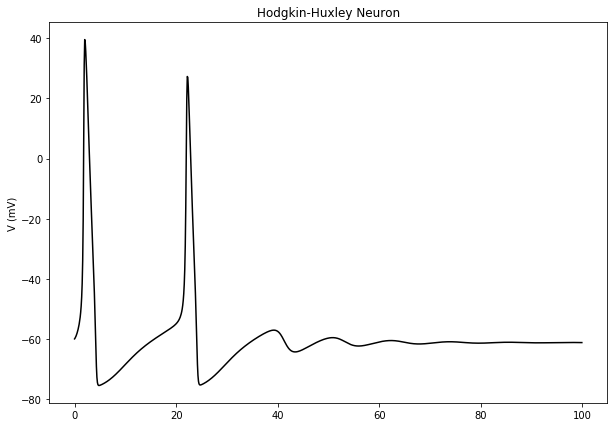

In [2]:
import torch
import torch.nn as nn
import time
import scipy as sp
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ========================= Constans ===============================
C_m = 1.0 #membrane capacitance, in uF/cm^2""" 
g_Na = 120.0 #Sodium (Na) maximum conductances, in mS/cm^2"" 
g_K = 36.0 #Postassium (K) maximum conductances, in mS/cm^2""" 
g_L = 0.3 #Leak maximum conductances, in mS/cm^2""" 
E_Na = 50.0 #Sodium (Na) Nernst reversal potentials, in mV""" 
E_K = -77.0 #Postassium (K) Nernst reversal potentials, in mV""" 
E_L = -54.387 #Leak Nernst reversal potentials, in mV""" 

N = 10  # Number Neurons
N_ex = 6 #(0..79) #
N_in = 4 #(80..99) 
G_ex = 1.0 
K = 4 

def poisson_spikes(t, N, rate=1.0): 
    spks = [] 
    dt = t[1] - t[0] 
    for n in range(N):
        spkt = t[np.random.rand(len(t)) < rate*dt/1000.] #Determine list of times of spikes 
        idx = [n]*len(spkt) #Create vector for neuron ID number the same length as time 
        spkn = np.concatenate([[idx], [spkt]], axis=0).T #Combine tw lists  
        spks.append(spkn) 
    spks = np.concatenate(spks, axis=0) 
    return spks 

def poisson_spikes_New(x, hidden_size): 
    spks = []; sp = []; out = []
    for n in range(hidden_size):
        idx = [n]*np.random.randint(1, 3) #Create vector for neuron ID number the same length as time
        v = [np.random.choice(x.view(-1).detach().numpy()) for i in range(len(idx))]
        spkt = [round(v[i]*np.random.randint(1, 100), 1) for i in range(len(idx))] #Determine list of times of spikes
        if spkt[-1] > 0.0:
            spkn = np.concatenate([[idx], [spkt]], axis=0).T #Combine tw lists  
            spks.append(spkn)
    spks = np.concatenate(spks, axis=0)
    return spks

dt = 0.1 
t = sp.arange(0.0, 100.0, dt) #The time to integrate over """ 
ic = [-60.0, 0.05, 0.6, 0.32] # Frist (V_0, m, h, n)

a = torch.randn(5, 5)
hidden_size = 10
lin = nn.Linear(a.size(0)*a.size(1), hidden_size, bias=True)
x = torch.sinh(lin(a.view(1, a.size(0)*a.size(1))))
print(x)

def alpha_m(V): 
     return 0.1*(V+40.0)/(1 - np.exp(-(V+40.0)/10.0))  #1.0 - np.exp(-(V+40.0)/10.0)
def beta_m(V): 
     return 4.0*np.exp(-(V+65.0)/18.0)
def alpha_h(V): 
     return 0.07*np.exp(-(V+65.0)/20.0)
def beta_h(V): 
     return 1.0/(1.0 + np.exp(-(V+35.0)/10.0)) 
def alpha_n(V): 
     return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0)/10.0)) 
def beta_n(V): 
     return 0.125*np.exp(-(V+65)/80.0) 
def I_Na(V, m, h): 
     return g_Na * np.power(m, 3.0) * h * (V - E_Na) 
def I_K(V, n): 
     return g_K * np.power(n, 4.0) * (V - E_K) 
def I_L(V): 
     return g_L * (V - E_L) 

def I_app(t): 
     return 6

def I_syn(spks, t): 
    """ 
    Synaptic current 
    spks = [[synid, t],] 
    """ 
    exspk = spks[spks[:,0]<N_ex] # Check for all excitatory spikes 
    delta_k = exspk[:,1] == t # Delta function 
    if np.any(delta_k) > 0: 
     h_k = np.random.rand(len(delta_k)) < 0.5 # p = 0.5 
    else: 
     h_k = 0 

    inspk = spks[spks[:,0] >= 8] #Check remaining neurons for inhibitory spikes 
    delta_m = inspk[:,1] == t #Delta function for inhibitory neurons 
    if np.any(delta_m) > 0: 
     h_m = np.random.rand(len(delta_m)) < 0.5 #p =0.5 
    else: 
     h_m = 0 

    isyn = C_m*G_ex*(np.sum(h_k*delta_k) - K*np.sum(h_m*delta_m)) 

    return isyn 

spike = poisson_spikes_New(x, hidden_size)

def dALLdt(X, t):
     dy = np.zeros((4,))
     V, m, h, n = X 
     dy[0] = (I_app(t)+I_syn(spike,t)-I_Na(V, m, h) - I_K(V, n) - I_L(V))/C_m
     dy[1] = alpha_m(V)*(1.0-m) - beta_m(V)*m 
     dy[2] = alpha_h(V)*(1.0-h) - beta_h(V)*h 
     dy[3] = alpha_n(V)*(1.0-n) - beta_n(V)*n 
     return dy

print(spike)

start_time = time.time()
X = odeint(dALLdt,ic,t) 
print("--- {:.4f} s ---".format(time.time() - start_time))
print(X)


X = np.array(X)  
V = X[:,0]   
m = X[:,1] 
h = X[:,2] 
n = X[:,3] 
ina = I_Na(V, m, h) 
ik = I_K(V, n) 
il = I_L(V)

plt.figure() 
plt.subplots(figsize=(10, 7)) 
plt.title('Hodgkin-Huxley Neuron') 
plt.plot(t, V, 'k') 
plt.ylabel('V (mV)') 


In [1]:
import torch
import torch.nn as nn
import time
import scipy as sp
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


class SNNCell(nn.Module):
    __constants__ = ['C_m', 'g_Na', 'g_K', 'g_L', 'E_Na', 'E_K', 'E_L']
    def __init__(self, device, input_size, hidden_size):
        super(SNNCell, self).__init__()
        self.C_m = 1.0; self.g_Na = 120.0; self.g_K = 36.0; self.g_L = 0.3
        self.E_Na = 50.0; self.E_K = -77.0; self.E_L = -54.387
        self.device = device
        self.hidden_size = hidden_size
        self.lin = nn.Linear(input_size, hidden_size, bias=True)
        
        self.init_parameters()
    
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
    
    def forward(self, t, state):
        dy = torch.zeros((4, self.hidden_size)).to(self.device)
        V, m, h, n = state
        _r_a = torch.randint(0, 10, (self.hidden_size, )).to(self.device)
        _activate = (torch.relu(self.lin(_i) - 1.0) > 0).float()
        
        dy[0] = (_r_a * _activate - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V))/self.C_m
        dy[1] = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m 
        dy[2] = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h 
        dy[3] = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return dy
    
    def alpha_m(self, V): 
         return 0.1*(V+40.0)/(1 - torch.exp(-(V+40.0)/10.0))
    def beta_m(self, V): 
         return 4.0*torch.exp(-(V+65.0)/18.0)
    def alpha_h(self, V): 
         return 0.07*torch.exp(-(V+65.0)/20.0)
    def beta_h(self, V): 
         return 1.0/(1.0 + torch.exp(-(V+35.0)/10.0)) 
    def alpha_n(self, V): 
         return 0.01*(V+55.0)/(1.0 - torch.exp(-(V+55.0)/10.0))
    def beta_n(self, V): 
         return 0.125*torch.exp(-(V+65)/80.0)
    def I_Na(self, V, m, h): 
         return self.g_Na * torch.pow(m, 3.0) * h * (V - self.E_Na)
    def I_K(self, V, n): 
         return self.g_K * torch.pow(n, 4.0) * (V - self.E_K)
    def I_L(self, V): 
         return self.g_L * (V - self.E_L)



In [2]:
class InputDataToSpikingPerceptronLayer(nn.Module):
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        self.to(self.device)

    def forward(self, x, is_2D=False):
        if is_2D is True:
            x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x


class SNN(nn.Module):
    def __init__(self, device, input_size, hidden_size, time_step=60, dt=0.1):
        super(SNN, self).__init__()
        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size[0] # Array [64, 24]
        self.time_step = time_step
        self.dt = dt
        
        self.input_to_spiking = InputDataToSpikingPerceptronLayer(self.device)
        self.spiking1 = SNNCell(self.device, input_size, self.hidden_size)
        #self.spiking2 = SNNCell(self.hidden_size, hidden_size[1])
        self.init_parameters()
        self.reset_state()
        self.to(self.device)    
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
                
    def reset_state(self):
        self.V = torch.zeros([self.hidden_size]).to(self.device)
        self.m = torch.zeros([self.hidden_size]).to(self.device)
        self.h = torch.zeros([self.hidden_size]).to(self.device)
        self.n = torch.zeros([self.hidden_size]).to(self.device)
        
    def forward(self, x):
        
        '''if self.V.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.V = torch.stack(batch_size * [self.V])
            self.m = torch.stack(batch_size * [self.m])
            self.h = torch.stack(batch_size * [self.h])
            self.n = torch.stack(batch_size * [self.n])'''
            
        self.V[:], self.m[:], self.h[:], self.n[:] = -60.0, 0.05, 0.6, 0.32
        _s = (self.V, self.m, self.h, self.n)
        _time = torch.arange(0.0, self.time_step, self.dt).to(self.device)
        global _i
        _i = self.input_to_spiking(x).to(self.device)
        _X = ode_torch(self.spiking1, _s, _time, rtol=1e-3, atol=1e-6, method='dopri5')
        
        
        #_X2 = ode_torch(self.spiking2, _s, _time, rtol=1e-3, atol=1e-6, method='dopri5')
        return _X
        
hidden_size = [64, 64]
input_size=2100
device = "cpu"
x = torch.randn(input_size).to(device)
model = SNN(device, input_size, hidden_size)
from torchdiffeq import odeint as ode_torch

test = 10; test_score = list()
for i in range(test):
    start_time = time.time()
    X = model(x) #dopri5, euler
    _time = time.time() - start_time
    test_score.append(_time)
    
print("--- Max: {:.4f} s --- Min: {:.4f} s --- Mean: {:.4f} s --- Error: {:.4f} s---".format(np.max(test_score)
                                                                                            ,np.min(test_score), sp.mean(test_score),
                                                                                            sp.std(test_score)))


--- Max: 7.3751 s --- Min: 5.8994 s --- Mean: 6.5056 s --- Error: 0.4338 ---


Text(0, 0.5, 'V (mV)')

<Figure size 432x288 with 0 Axes>

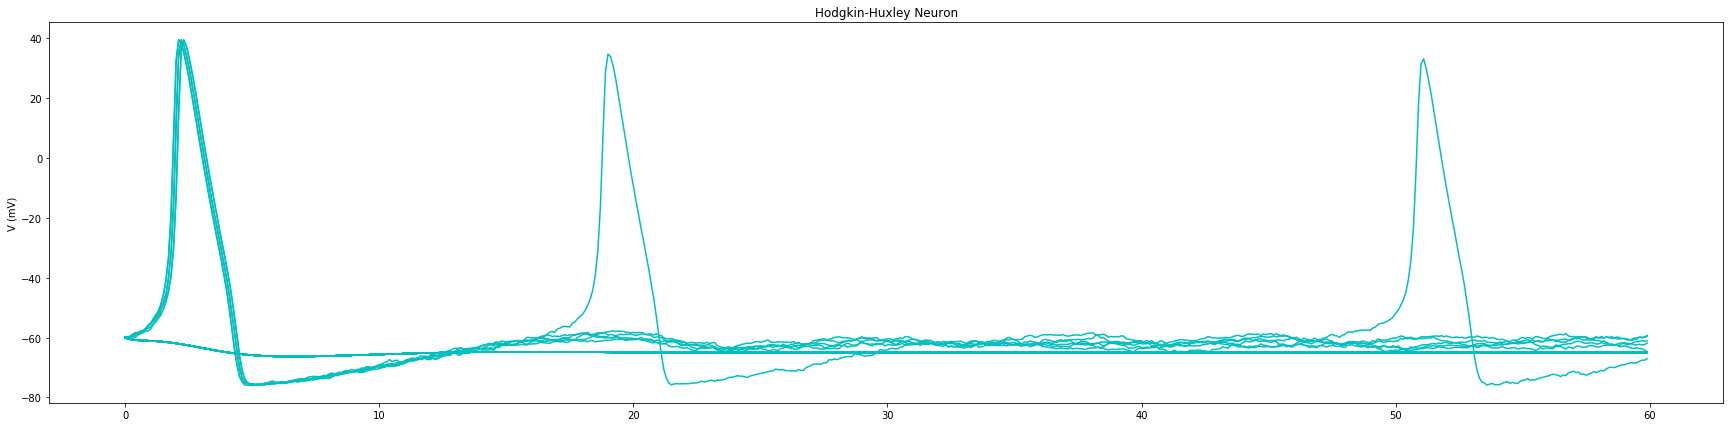

<Figure size 432x288 with 0 Axes>

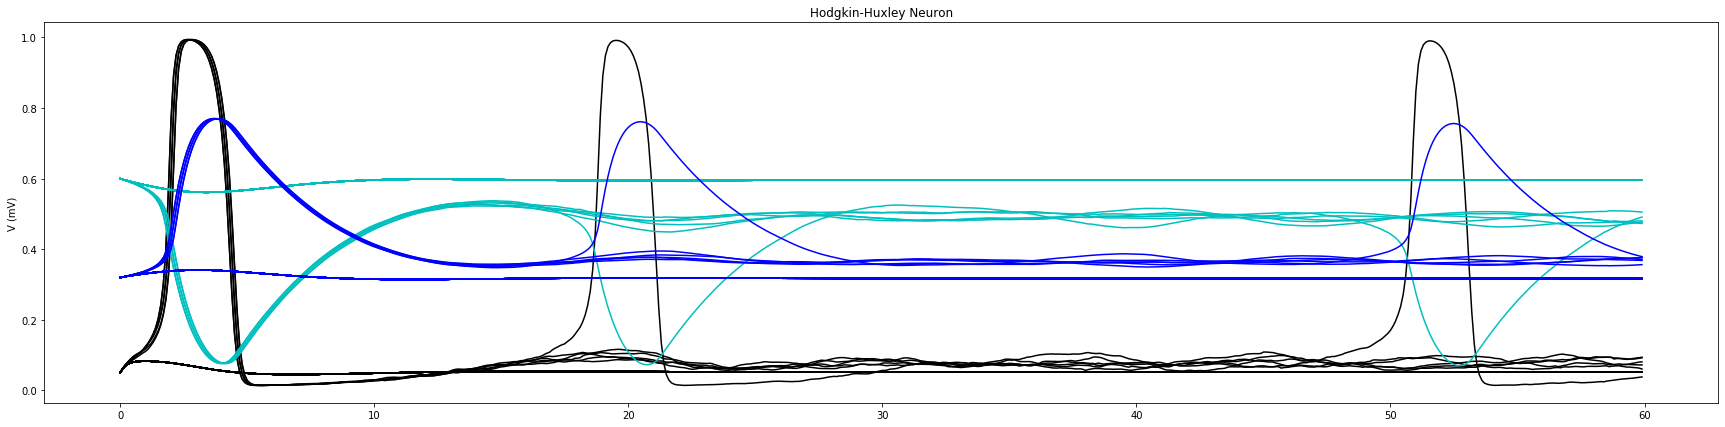

In [6]:
time_step=60;dt=0.1
t = torch.arange(0.0, time_step, dt).to(device)
plt.figure()
plt.subplots(figsize=(30, 7)) 
plt.title('Hodgkin-Huxley Neuron') 
plt.plot(t.cpu(), X[0].cpu(), 'c') #t, X[0]
plt.ylabel('V (mV)') 

plt.figure() 
plt.subplots(figsize=(30, 7)) 
plt.title('Hodgkin-Huxley Neuron') 
plt.plot(t.cpu(), X[1].cpu().detach().numpy(), 'k')
plt.plot(t.cpu(), X[2].cpu().detach().numpy(), 'c')
plt.plot(t.cpu(), X[3].cpu().detach().numpy(), 'b')
plt.ylabel('V (mV)') 

In [7]:
for i in range(hidden_size[0]):
    print(torch.max(X[0][:, i].cpu()),"\t", i)

tensor(-60.) 	 0
tensor(-60.) 	 1
tensor(-60.) 	 2
tensor(-60.) 	 3
tensor(-60.) 	 4
tensor(-60.) 	 5
tensor(-60.) 	 6
tensor(39.5182) 	 7
tensor(39.5362) 	 8
tensor(39.1912) 	 9
tensor(-60.) 	 10
tensor(-60.) 	 11
tensor(-60.) 	 12
tensor(-60.) 	 13
tensor(39.6065) 	 14
tensor(-60.) 	 15
tensor(39.6230) 	 16
tensor(-60.) 	 17
tensor(-60.) 	 18
tensor(-60.) 	 19
tensor(-60.) 	 20
tensor(-60.) 	 21
tensor(-60.) 	 22
tensor(-60.) 	 23
tensor(-60.) 	 24
tensor(-60.) 	 25
tensor(-60.) 	 26
tensor(-60.) 	 27
tensor(-60.) 	 28
tensor(-60.) 	 29
tensor(-60.) 	 30
tensor(-60.) 	 31
tensor(-60.) 	 32
tensor(-60.) 	 33
tensor(-60.) 	 34
tensor(-60.) 	 35
tensor(-60.) 	 36
tensor(-60.) 	 37
tensor(-60.) 	 38
tensor(-60.) 	 39
tensor(-60.) 	 40
tensor(-60.) 	 41
tensor(-60.) 	 42
tensor(-60.) 	 43
tensor(-60.) 	 44
tensor(-60.) 	 45
tensor(-60.) 	 46
tensor(-60.) 	 47
tensor(-60.) 	 48
tensor(39.5407) 	 49
tensor(-60.) 	 50
tensor(-60.) 	 51
tensor(-60.) 	 52
tensor(-60.) 	 53
tensor(-60.) 	 54
te

In [9]:
v = torch.max(X[0]).item()
i = X[0].max(1)[1][1].item()
print(v, "\t", i)

print(X[0][:, 21])
print(X[1][:, 21])
print(X[2][:, 21])
print(X[3][:, 21])

39.62302017211914 	 49
tensor([-60.0000, -60.3240, -60.5537, -60.7086, -60.8109, -60.8794, -60.9283,
        -60.9674, -61.0033, -61.0400, -61.0806, -61.1270, -61.1802, -61.2412,
        -61.3104, -61.3881, -61.4744, -61.5692, -61.6727, -61.7844, -61.9041,
        -62.0314, -62.1656, -62.3063, -62.4527, -62.6041, -62.7597, -62.9185,
        -63.0799, -63.2428, -63.4064, -63.5696, -63.7319, -63.8922, -64.0500,
        -64.2044, -64.3549, -64.5009, -64.6420, -64.7777, -64.9078, -65.0319,
        -65.1499, -65.2618, -65.3672, -65.4664, -65.5592, -65.6457, -65.7262,
        -65.8006, -65.8691, -65.9320, -65.9889, -66.0409, -66.0876, -66.1293,
        -66.1663, -66.1987, -66.2269, -66.2510, -66.2711, -66.2875, -66.3005,
        -66.3101, -66.3166, -66.3201, -66.3209, -66.3191, -66.3149, -66.3084,
        -66.2998, -66.2891, -66.2768, -66.2626, -66.2469, -66.2298, -66.2112,
        -66.1914, -66.1705, -66.1486, -66.1257, -66.1019, -66.0774, -66.0522,
        -66.0264, -66.0001, -65.9732, -65